In [179]:
set.seed(1)
suppressPackageStartupMessages(require(rstan))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(dplyr))
sd = 1

### Setup

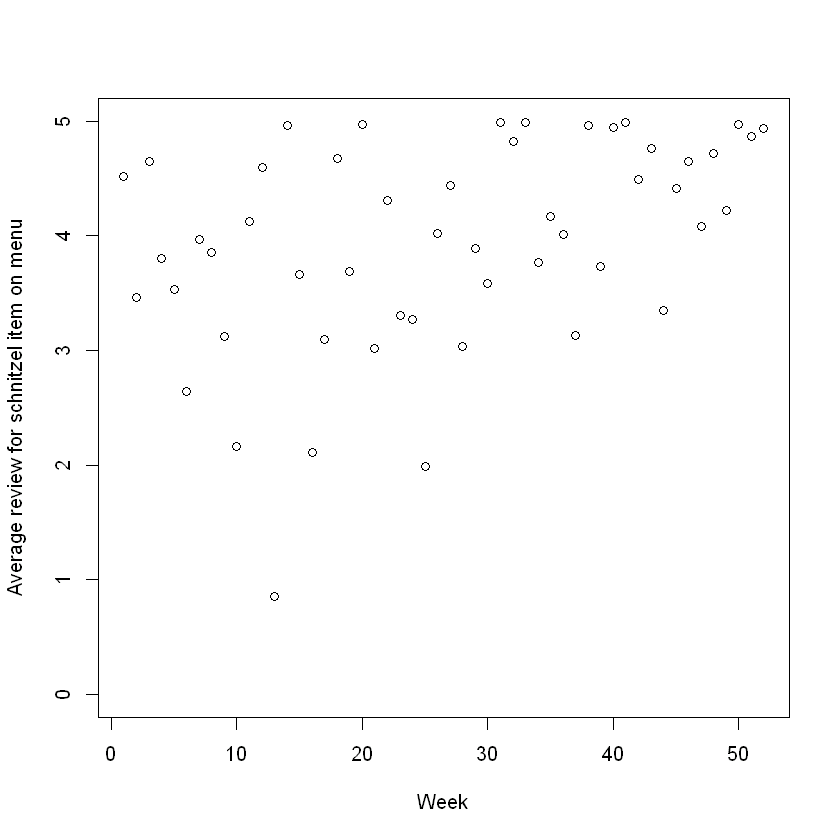

In [180]:
food_data = c(4.52, 3.46, 4.65, 3.8, 3.53, 2.64, 3.97, 3.86, 3.12, 2.16, 4.13, 4.6, 0.86,
    4.96, 3.66, 2.11, 3.1, 4.68, 3.69, 4.97, 3.02, 4.31, 3.31, 3.27, 1.99, 4.02,
    4.44, 3.04, 3.89, 3.59, 4.99, 4.82, 4.99, 3.77, 4.17, 4.01, 3.13, 4.96, 3.73, 4.95,
    4.99, 4.49, 4.76, 3.35, 4.41, 4.65, 4.08, 4.72, 4.22, 4.97, 4.87, 4.94)
plot(1:length(food_data), food_data, xlab = "Week", ylab = "Average review for schnitzel item on menu", 
ylim = c(0,5), xlim = c(1, 52))

In [181]:
log_joint = function(means, change_point, y) {
  
  # Return log(0.0) if parameters are outside of the support
  if (means[1] < 0.1 | means[2] < 0.1 | means[1] > 0.9 | means[2] > 0.9 | change_point < 1 | change_point > length(y)) 
    return(-Inf)
  
  log_prior = 
    dunif(means[1], 0.1, 0.9, log = TRUE) + 
    dunif(means[2], 0.1, 0.9, log = TRUE)
  
  log_likelihood = 0.0
  for (i in 1:length(y)) {
    mean = if (i < change_point) means[1] else means[2]
    log_likelihood = log_likelihood + dbeta(y[i]/5, mean*5, (1-mean)*5, log = TRUE)
  }
  
  return(log_prior + log_likelihood)
}

### Q1: A custom MCMC sampler

In [ ]:
# 3
mcmc = function(means, change_point, y, n_iterations) {
  change_point_trace = rep(-1, n_iterations)
  for (i in 1:n_iterations) {
    # K2 for c
    proposed_c = floor(rnorm(1, change_point, sd) + 0.5) # discrete normal proposal
    # proposed_c = rnorm(1, change_point, sd = sd)
    # proposed_c = ifelse(proposed_c >= change_point, ceiling(proposed_c), floor(proposed_c)) # proposal
    ratio = exp(log_joint(means, proposed_c, y) - log_joint(means, change_point, y)) # M-H ratio
    # n = 2 * change_point
    # proposed_c = rbinom(1, n, 0.5)
    # ratio = exp(log_joint(means, proposed_c, y) - log_joint(means, change_point, y) + dbinom(proposed_c, n, 0.5, log=TRUE) - dbinom(change_point, n, 0.5, log=TRUE)) # M-H ratio
    change_point = ifelse(runif(1) < min(ratio,1), proposed_c, change_point) # acceptance
    change_point_trace[i] = change_point
    # K1 for mu
    proposed_mu = rnorm(2, means, 0.1)
    ratio = exp(log_joint(proposed_mu, change_point, y) - log_joint(means, change_point, y))
    if (runif(1) < min(ratio, 1)) {
      means = proposed_mu
    }
    # means = ifelse(runif(1) < min(ratio,1), proposed_mu, means) # !!! VERY ANNOYING BUG
  }
  
  # Return:
  # - the trace of the change points (for question 1) 
  # - the means at the last iteration (for question 2)
  return(
    list(
      change_point_trace = change_point_trace, 
      last_iteration_means = means 
    )
  )
}

### Q2: MCMC correctness testing

In [183]:
# 1
forward = function(synthetic_data_size) {
  means = runif(2, 0.1, 0.9)
  change_point = ceiling(runif(1, 0, synthetic_data_size))
  data = numeric(synthetic_data_size)
  for (i in 1:synthetic_data_size) {
    index = ifelse(i >= change_point, 1, 0) + 1
    data[i] = 5 * rbeta(1, means[index]*5, (1-means[index])*5)
  } 
  return(list(
    means = means,
    change_point = change_point,
    data = data
  ))
}

In [184]:
forward_posterior = function(synthetic_data_size, n_mcmc_iters) {
  initial = forward(synthetic_data_size)
  if (n_mcmc_iters > 0) {
    samples = mcmc(initial$means, initial$change_point, initial$data, n_mcmc_iters)
    return(samples$last_iteration_means[1])
  } else {
    return(initial$means[1])
  }
}

In [185]:
# 2
# Note: we use synthetic datasets with only 5 observations to speed things up
forward_only = replicate(1000, forward_posterior(5, 0))
with_mcmc = replicate(1000, forward_posterior(5, 200))

# TODO: perform 2-samples t-test or Kolmogorov-Smirnov test
#       to see if forward_only and with_mcmc follow the same distribution. 
ks.test(forward_only, with_mcmc)


	Asymptotic two-sample Kolmogorov-Smirnov test

data:  forward_only and with_mcmc
D = 0.025, p-value = 0.9135
alternative hypothesis: two-sided


### Q3: Using your sampler for data analysis

In [190]:
sd = 6
initial_mu = runif(2, 0.1, 0.9)
initial_c = ceiling(runif(1, 0, length(food_data)))
samples = mcmc(initial_mu, initial_c, food_data, 10000)

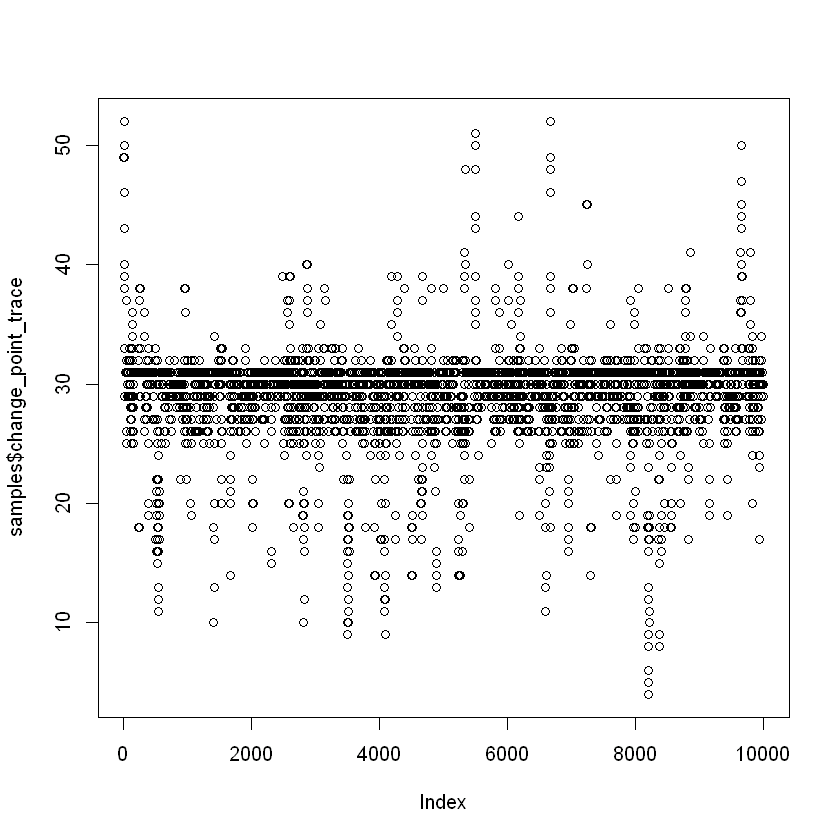

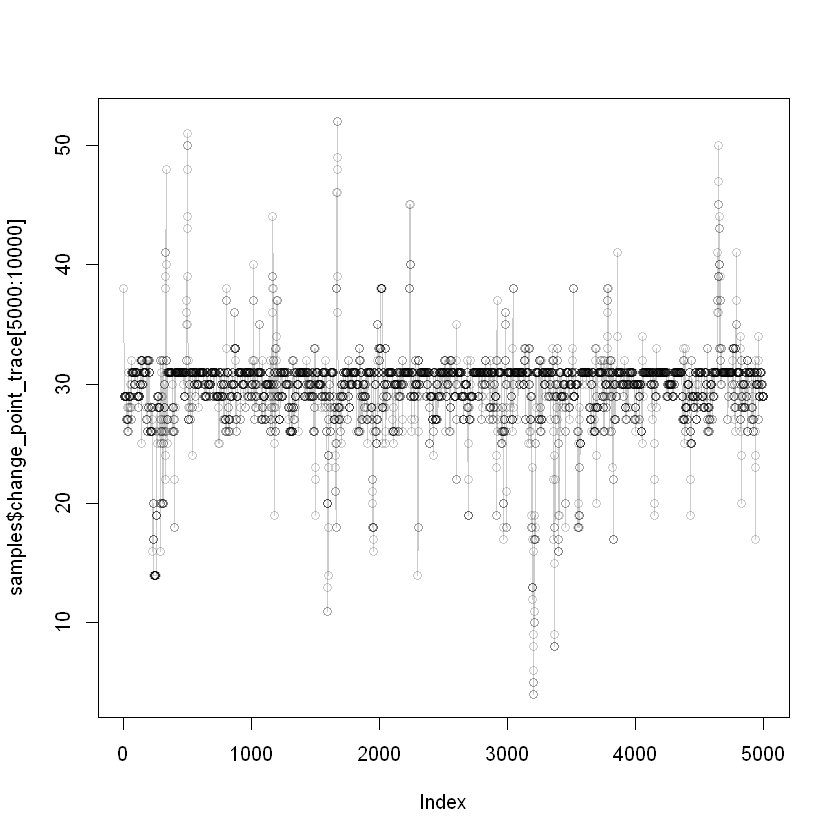

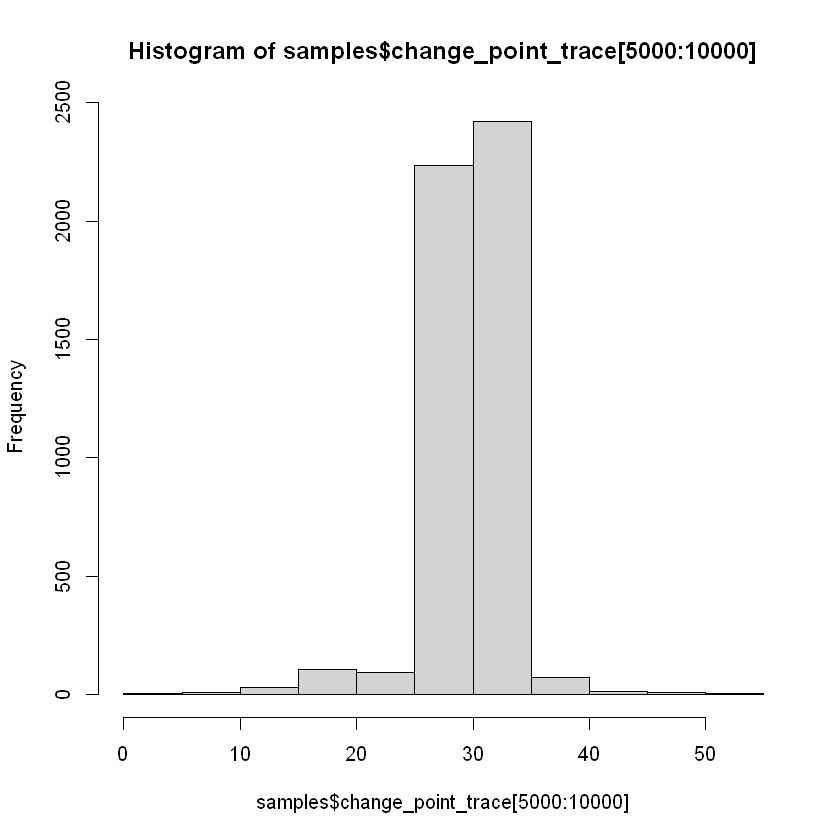

In [191]:
# df = data.frame(x = seq(1:10000), y = samples$change_point_trace)
# ggplot(df, aes(x = x, y = y)) +
#     geom_line(alpha = 0.3) +
#     labs(
#         title = "Trace Plot",
#         x = "Iteration",
#         y = "Change point"
#     )

# ggplot(df[5000:10000, ], aes(x = x, y = y)) +
#     geom_line() +
#     labs(
#         title = "Trace Plot",
#         x = "Iteration",
#         y = "Change point"
#     )
# ggplot(df[5000:10000, ], aes(x = y)) +
#   geom_histogram(binwidth = 0.5) +  # adjust binwidth as needed
#   labs(
#     title = "Histogram of Samples",
#     x = "change point",
#     y = "Count"
#   )


plot(samples$change_point_trace)
plot(samples$change_point_trace[5000:10000], axes = TRUE, type = "o", col = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))
hist(samples$change_point_trace[5000:10000])
